In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Tuple
from tqdm import tqdm
from matplotlib import cm

np.random.seed(42)

# Neural Modelling exercise 3: Temporal learning and acting
# By: Robin Uhrich* and Ieva Kerseviciute*
\* equal contribution

## TD Learning

Recreate figure 9.2 (page 15) of the book chapter we provided.

Experiment with following parameters. Plot and briefly describe your observations for each.

- Reward timing
- Learning rate
- Multiple rewards
- Stochastic rewards

(Note that you will have to think about how to represent the time between the stimulus and the reward).

In [2]:
def add_stimulus(series: np.ndarray, t: int = 100, std: float = 0):
    # add a gaussian stimulus at time t and with distribution std
    if std != 0:
        raise NotImplementedError("Currently assuming only point mass stimulus")

    series[t] += 1
    return series


def add_reward(series: np.ndarray, t: int = 200, std: float = 2):
    x = np.arange(len(series))
    y = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - t) ** 2 / std ** 2)
    return series + y


length = 300
stimulus = np.zeros(length)
stimulus = add_stimulus(stimulus)
reward = np.zeros(length)
reward = add_reward(reward)

In [3]:
def get_value(weights: np.ndarray, stimulus: np.ndarray) -> np.ndarray:
    """
    Calculates the total future reward using the current weights.
    
    :param weights: vector of weights
    :param stimulus: vector of stimuli
    :return: total future reward
    """
    v = np.zeros_like(weights)
    length = len(weights)
    for t in range(length):
        v[t] = np.dot(weights[:t], stimulus[1: t + 1][::-1])
    return v


def get_delta(reward: np.ndarray, value: np.ndarray) -> np.ndarray:
    """
    Calculates the difference between the actual and predicted total future reward.
    
    :param reward: actual future reward
    :param value: predicted total future reward
    :return: difference between the actual and predicted total future reward
    """
    future_value = value[1:]
    current_value = value[:-1]
    delta = reward[:-1] + future_value - current_value
    return delta


def learn_step(weights: np.ndarray, stimulus: np.ndarray, delta: np.ndarray, epsilon: float) -> np.ndarray:
    """
    Calculates the weights for a single learning step.
    
    :param weights: current weights
    :param stimulus: vector of stimuli
    :param delta: difference between the actual and predicted total future reward
    :param epsilon: learning rate
    :return: updated vector of weights
    """
    length = len(weights)
    for t in range(length - 1):
        weights[:t] += epsilon * delta[t] * stimulus[1: t + 1][::-1]
    return weights


def td_learning(stimulus: np.ndarray, reward: np.ndarray, epsilon: float = 0.98, n_trials: int = 100):
    """
    Temporal difference learning.
    
    :param stimulus: vector of stimuli 
    :param reward: vector of rewards
    :param epsilon: learning rate
    :param n_trials: number of trials
    :return: history of temporal difference learning, containing value, weight,
             and delta change over time
    """
    if len(stimulus.shape) == 1:
        # stack it n_trials open 
        stimulus = stimulus[None].repeat(n_trials, axis = 0)
    elif len(stimulus.shape) == 2:
        assert len(stimulus) == n_trials
    else:
        raise ValueError("stimulus does not have the right shape")

    if len(reward.shape) == 1:
        # stack it n_trials open 
        reward = reward[None].repeat(n_trials, axis = 0)
    elif len(reward.shape) == 2:
        assert len(reward) == n_trials
    else:
        raise ValueError("reward does not have the right shape")

    weights = np.zeros(stimulus.shape[1])
    history = {
        "value": [],
        "weights": [],
        "deltas": [],
    }
    for epoch_idx in tqdm(range(n_trials)):
        value = get_value(weights, stimulus[epoch_idx])
        deltas = get_delta(reward[epoch_idx], value)
        weights = learn_step(weights, stimulus[epoch_idx], deltas, epsilon)

        history["deltas"].append(deltas)
        history["value"].append(value)
        history["weights"].append(weights)

    for key in history.keys():
        history[key] = np.stack(history[key])
    return history

In [4]:
def plot_surface(z: np.ndarray, label: str = ""):
    fig, ax = plt.subplots(subplot_kw = { "projection": "3d" })

    # Make data.
    X = np.arange(z.shape[1])
    Y = np.arange(z.shape[0])
    X, Y = np.meshgrid(X, Y)

    # Plot the surface.
    ax.view_init(15, -76, 0)
    ax.plot_surface(X, Y, z, cmap = cm.seismic)
    ax.set_xlabel("t")
    ax.set_ylabel("trials")
    ax.set_zlabel(label)


def plot_comparison(stimulus, reward, history):
    fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, sharey = "row")
    axes[0, 0].set_title("before")
    axes[0, 1].set_title("after")
    axes[0, 1].set_ylabel(r"$u$")
    axes[1, 1].set_ylabel(r"$r$")
    axes[2, 1].set_ylabel(r"$v$")
    axes[3, 1].set_ylabel(r"$\triangle v$")
    axes[4, 1].set_ylabel(r"$\delta$")

    axes[0, 0].plot(stimulus, c = "k")
    axes[0, 1].plot(stimulus, c = "k")

    axes[1, 0].plot(reward, c = "k")
    axes[1, 1].plot(reward, c = "k")

    axes[2, 0].plot(history["value"][0], c = "k")
    axes[2, 1].plot(history["value"][-1], c = "k")

    axes[3, 0].plot(np.diff(history["value"][0]), c = "k")
    axes[3, 1].plot(np.diff(history["value"][-1]), c = "k")

    axes[4, 0].plot(history["deltas"][0], c = "k")
    axes[4, 1].plot(history["deltas"][-1], c = "k")

    axes[4, 0].set_xlabel("t")
    axes[4, 1].set_xlabel("t")

    for ax in axes.flatten():
        ax.axvline(100, color = "k", linestyle = "dotted")

### Recreating the figure 9.2

In [5]:
epsilon = 0.8
n_trials = 200
history = td_learning(stimulus, reward, n_trials = n_trials, epsilon = epsilon)

100%|██████████| 200/200 [00:00<00:00, 1520.51it/s]


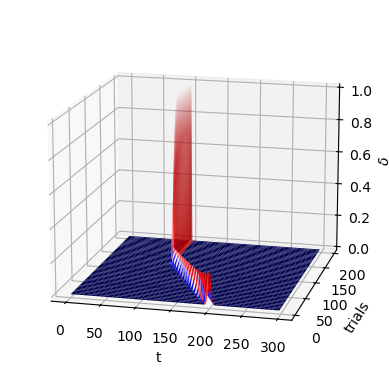

In [6]:
plot_surface(history["deltas"], label = r"$\delta$")

We ran the temporal difference learning algorithm for 200 trials with a learning rate of 0.8, presenting the stimulus at time $t = 100$ and the reward at time $t = 200$. As expected, we notice that the td-error over time shifts towards the time of the stimulus and decays exponentially corresponding to the learning rate. The td-error reaches its maximal at the time of the stimulus as the integral of the reward signal over time after the stimulus was provided. 

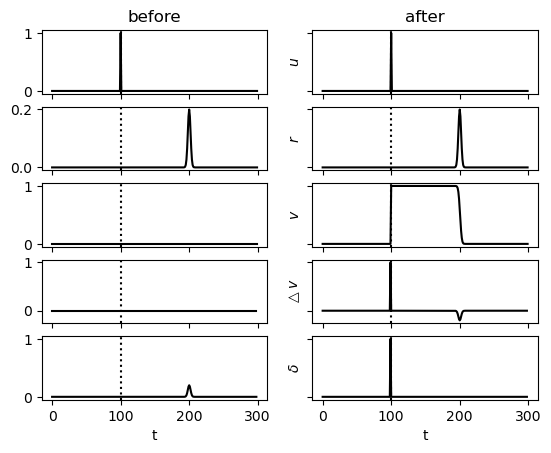

In [7]:
plot_comparison(stimulus, reward, history)

Before the trials, no prediction $v$ for the future reward is made (and thus, no difference between the predictions $\Delta v$ is visible). The difference between the actual and predicted total future reward $\delta$ is equal to the actual reward.

After the trials, the predicted total future reward $v$ suddenly increases at the time of the stimulus, and then drops once the reward is presented. The temporal difference between predictions $\Delta v$ resembles a delta function at the time of the stimulus and dips during the time point of the reward (as expected, the largest difference between the predictions $v$ is during the stimulus onset; the dip can be explained by the falling phase of the predictions $v$). The difference between the actual and predicted total future reward $\delta$ shifts in time to the stimulus onset, and predicts full reward at that time point.

### Reward timing

100%|██████████| 200/200 [00:00<00:00, 1521.50it/s]


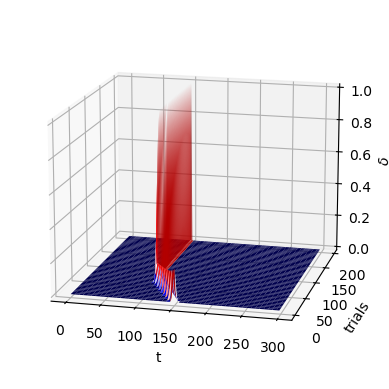

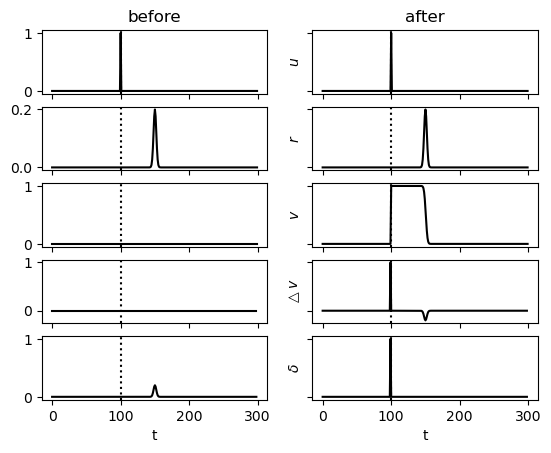

In [8]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 150)

history = td_learning(stimulus, reward, epsilon, n_trials)
plot_surface(history["deltas"], label = r"$\delta$")
plot_comparison(stimulus, reward, history)

We presented the reward at time $t = 150$, maintaining the stimulus time at $t = 100$. The results resemble the case when the reward is presented at time $t = 200$, with the difference between the actual and predicted total future reward $\delta$ shifting in time to the time point of the stimulus onset.

100%|██████████| 200/200 [00:00<00:00, 1519.18it/s]


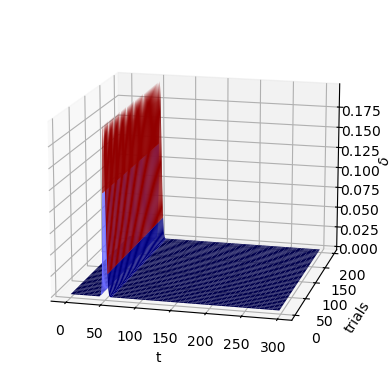

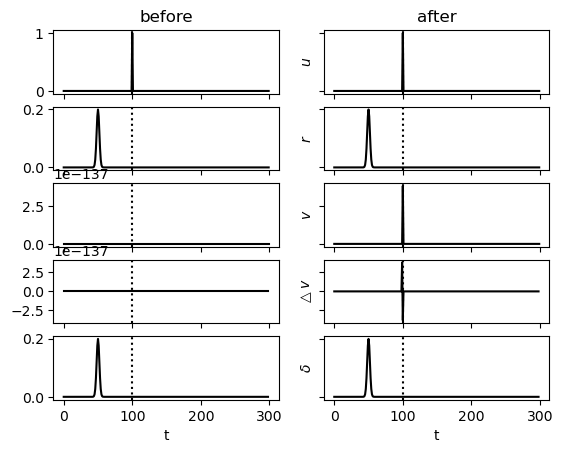

In [9]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 50)

history = td_learning(stimulus, reward, epsilon, n_trials)
plot_surface(history["deltas"], label = r"$\delta$")
plot_comparison(stimulus, reward, history)

Now, we presented the reward at time $t = 50$, maintaining the stimulus time at $t = 100$. In this case, the difference between the actual and predicted total future reward $\delta$ does not shift to the time of the stimulus because our update signal (td-error) propagates only backward in time. Therefore, the past is not influenced by the future. Although we can observe a non-zero value prediction at the time of the stimulus. This comes from the fact that our weight update runs (as $\tau$) from $0$ to $t$ with a constant $\delta(t)$. If now the stimulus was presented, the weight update is non-zero and integrates with the weight update while we are training with a reward presented. If we do not present a stimulus anymore the weight stays constant.

### Learning Rate

100%|██████████| 200/200 [00:00<00:00, 1527.56it/s]


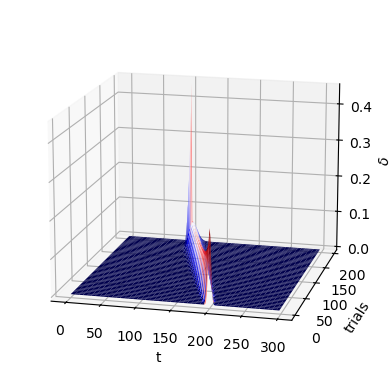

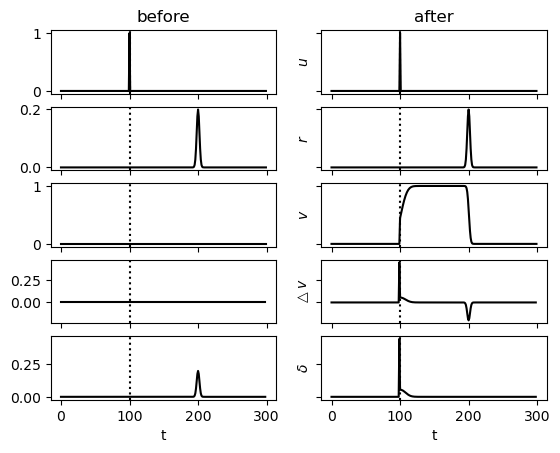

In [10]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 200)

history = td_learning(stimulus, reward, 0.50, n_trials)
plot_surface(history["deltas"], label = r"$\delta$")
plot_comparison(stimulus, reward, history)

In the case of a lower learning rate, the predictions $v$, difference between predictions $\Delta v$ and the difference between the actual and predicted total future reward $\delta$ do not fully converge in the same number of trials. The weights are updated in a slower manner, and thus it takes longer to fully form the association between the stimulus and the reward.

## Multiple Rewards

100%|██████████| 200/200 [00:00<00:00, 1529.72it/s]


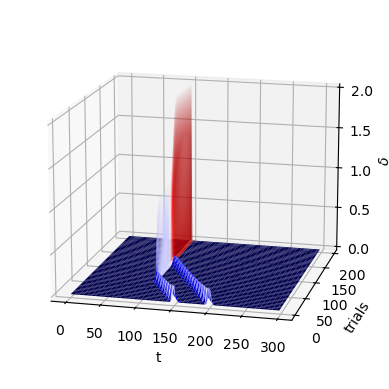

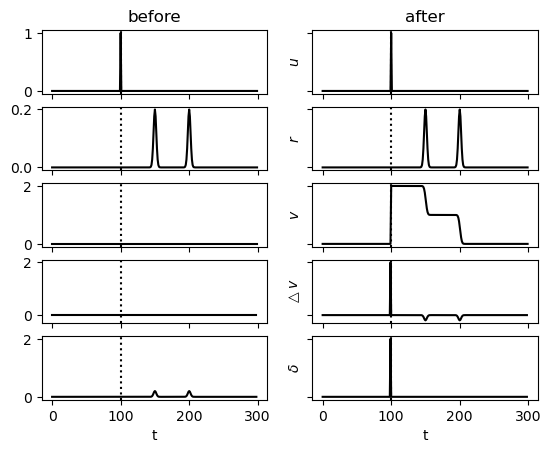

In [11]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 150)
reward = add_reward(reward, 200)

history = td_learning(stimulus, reward, epsilon, n_trials)
plot_surface(history["deltas"], label = r"$\delta$")
plot_comparison(stimulus, reward, history)

Here, we present a stimulus at time $t = 100$ and two rewards: one at time $t = 150$, and another at time $t = 200$. After training, the predicted future reward $v$ drops after the first reward is presented by the integral of the first reward, and eventually to zero after the presentation of both rewards. The difference between predictions $\Delta v$ in this case has two dips instead of one, relating to the two drops in the total predicted future reward $v$. The difference between the actual and predicted total future reward $\delta$ is shifted in time to the time point of the stimulus to predict both rewards.

### Stochastic rewards

100%|██████████| 200/200 [00:00<00:00, 1384.43it/s]


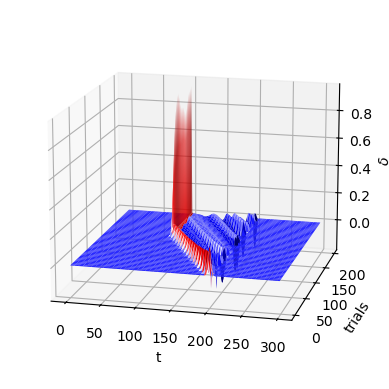

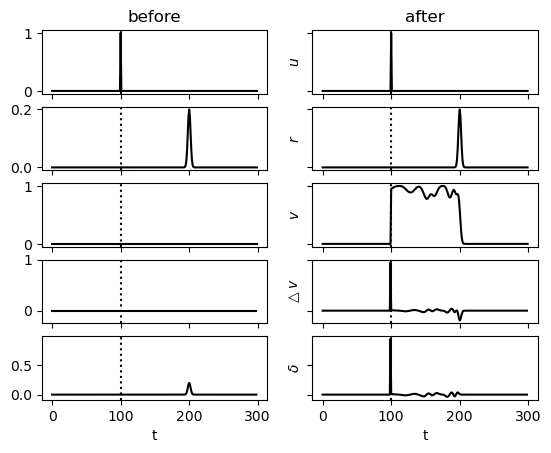

In [12]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 200)
binary_mask = np.random.binomial(1, 0.9, n_trials)
random_reward = reward[None] * binary_mask[:, None]

history = td_learning(stimulus, random_reward, epsilon, n_trials)
plot_surface(history["deltas"], label = r"$\delta$")
plot_comparison(stimulus, reward, history)

As random reward we took the standard reward signal as presented in the previous experiments but switched it on or off with a probability of 0.5. In the comparison we present results with a switched on reward. For a switched off reward there is just no reward signal and a slightly different $\delta$ ($\Delta v = \delta$).

In the 3D surface we can see a positive amplitude if the reward was presented and a negative amplitude if no reward was presented and the agent was already conditioned towards a reward. Additionally, we can see in the comparison on the right hand side of the plot a value prediction noisy and close to one but not equal to one because of the random reward. 

## Successor learning


We will learn the successor representation (discounted future state occupancies) for a simple grid-world under a random walk policy. We will use the grid-world of the shown figure, refer to the Python code we provided for an implementation of this grid.

Implement a random walk policy (up, down, left, or right with equal probability), filling in the provided function stub. Given a maze, a starting location, and a number of steps, perform the specified number of random moves from the starting location. Make sure to exclude impossible moves (don’t just stay at the current spot when such a move is attempted, but pick a different one instead). Use the provided function to plot such a trajectory.

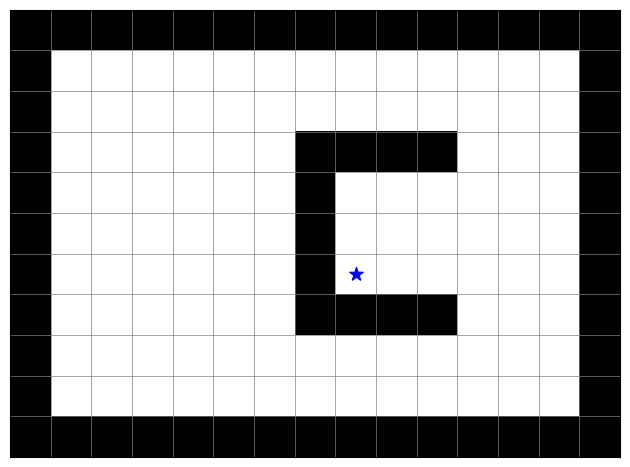

In [3]:
# define maze

maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (6, 8)

# pad maze
pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad


def plot_maze(maze) -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.imshow(maze, cmap = 'binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        ax.plot([-0.5, maze.shape[1] - 0.5], [i - 0.5, i - 0.5], c = 'gray', lw = 0.5)
    for i in range(maze.shape[1]):
        ax.plot([i - 0.5, i - 0.5], [-0.5, maze.shape[0] - 0.5], c = 'gray', lw = 0.5)

    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax


plot_maze(maze)
plt.scatter(start[1], start[0], marker = '*', color = 'blue', s = 100)
plt.tight_layout()
plt.show()

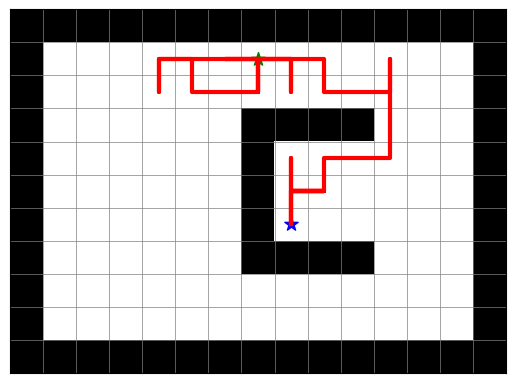

In [4]:
def random_walk(maze, start, n_steps):
    # Perform a single random walk in the given maze, starting from start, performing n_steps random moves.
    # Moves into the wall and out of the maze boundary are not possible.

    # initialize list to store positions
    positions = np.empty((n_steps + 1, len(maze.shape)), dtype = int)
    positions[0] = start

    # perform random steps...
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype = int)
    for i in range(n_steps):
        move_options = positions[i][None] + possible_moves
        # remove those moves which run into a barrier
        move_options = 1 - maze[*move_options.T]
        # int prob distribution
        p = move_options / move_options.sum()
        move_idx = np.random.choice(len(possible_moves), p = p)
        move = possible_moves[move_idx]
        positions[i + 1] = positions[i] + move

    # return a list of length n_steps + 1, containing the starting position and all subsequent locations as e.g. tuples or size (2) arrays 
    return positions


def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c = 'red', lw = 3)
    plt.scatter(path[0, 1], path[0, 0], marker = '*', color = 'blue', s = 100)
    plt.scatter(path[-1, 1], path[-1, 0], marker = '*', color = 'green', s = 100)
    plt.show()


# plot a random path
path = random_walk(maze, start, 40)
plot_path(maze, path)

Write a function which takes a trajectory of grid positions and the current state of your learned successor representation (SR; for this environment it is practical to implement the SR as a matrix, corresponding to the grid). Then, based on the provided trajectory, update the successor representation matrix of the starting state, being sure to discount future states appropriately. Repeat this a number of times with different examples, as outlined in our code, to learn a representation from examples. Plot the learned representation.

  0%|          | 0/5001 [00:00<?, ?it/s]

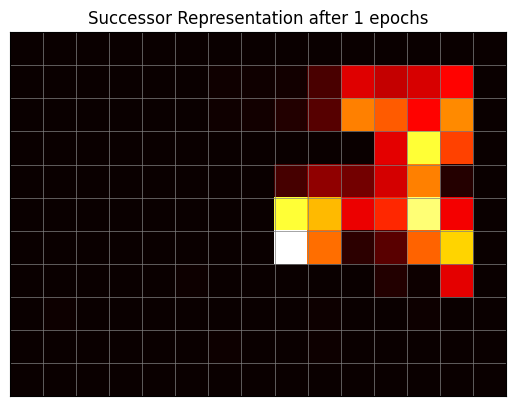

  0%|          | 6/5001 [00:00<03:36, 23.12it/s]

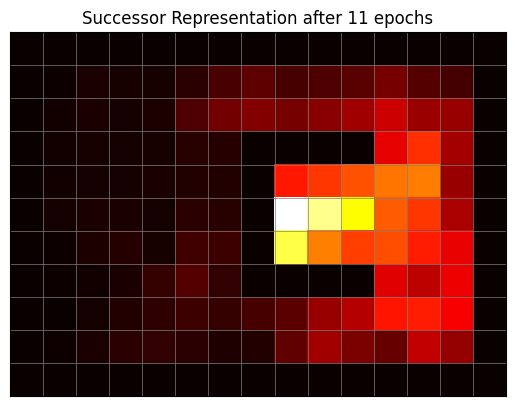

  2%|▏         | 95/5001 [00:02<01:35, 51.13it/s]

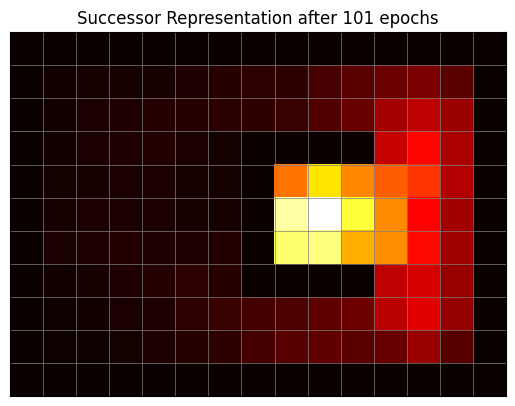

  2%|▏         | 102/5001 [00:02<01:53, 43.09it/s]


KeyboardInterrupt: 

In [5]:
def learn_from_traj(succ_repr, trajectory, gamma = 0.98, alpha = 0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha

    discount = 1
    for point in trajectory:
        succ_repr[*point] += alpha * discount
        discount *= gamma

    # return the updated successor representation
    return succ_repr


# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in tqdm(range(5001)):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha = 0.02)  # choose a small learning rate

    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        fig, ax = plot_maze(maze)
        ax.set_title(f"Successor Representation after {i + 1} epochs")
        ax.imshow(succ_repr, cmap = 'hot')
        plt.show()

In the previous code we sample 5001 random walk trajectories (length = 340) and apply successor learning. Successor learning means to update a cell value by the discounted visit count.

Compute the overall transition matrix, based on the maze layout. Note that this matrix has size 117×117 (as 9*13=117), to represent the probability for transitioning from any state into any other. (Rows which correspond to an impossible state, a wall, contain only zeros, make sure to remove NaNs here).

In [6]:
def compute_transition_matrix(maze: np.ndarray) -> np.ndarray:
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    n_states = len(maze.flatten())
    transitions = np.zeros((n_states, n_states))

    indices = np.arange(n_states).reshape(maze.shape)

    # only vertical or horizontal moves allowed
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype = int)

    # allow diagonal moves
    # possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [1, 1], [1, -1], [-1, 1], [-1, -1]], dtype=int)

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for state_idx, (i, j) in enumerate(
            product(range(maze.shape[0]), range(maze.shape[1]))
    ):
        cell = maze[i, j]
        if cell == 1:
            continue

        coords = np.array([i, j])
        move_options = coords + possible_moves
        future_cell_values = maze[*move_options.T]
        move_options = move_options[~future_cell_values.astype(bool)]
        future_states = indices[*move_options.T]
        # print(coords, future_states)
        transitions[state_idx, future_states] += 1
        # normalize transitions if necessary
        transitions[state_idx] /= transitions[state_idx].sum()

    return transitions

transitions = compute_transition_matrix(maze)

Recompute the successor representation at the starting position by repeatedly applying the transition matrix you computed (for this it is opportune to turn the SR matrix into a vector).

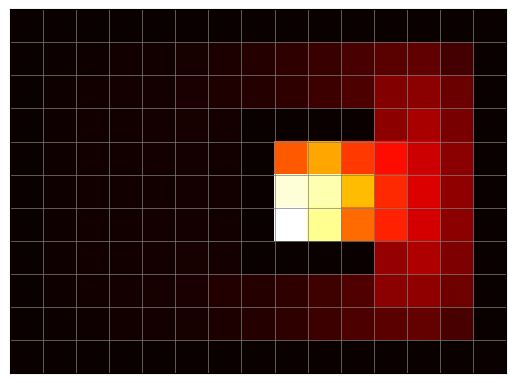

In [11]:
def compute_sr(transitions, i, j, maze, gamma = 0.98):
    """
    given a transition matrix and a specific state (i, j).
    compute the successor representation of that state with discount factor gamma
    """

    # initialize things (better to represent the current discounted occupancy as a vector here)
    n_states = len(transitions)
    current_discounted_occupancy = np.zeros(n_states)
    total = current_discounted_occupancy.copy()

    one_hot_start = np.zeros(n_states)
    one_hot_start[i * maze.shape[1] + j] = 1

    # iterate for a number of steps
    tx = np.eye(n_states)
    for _ in range(340):
        current_discounted_occupancy = tx.T @ one_hot_start
        total += current_discounted_occupancy
        tx = gamma * tx.T @ transitions

    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(maze.shape)


sr = compute_sr(transitions, *start, maze)
_, ax = plot_maze(maze)
ax.imshow(sr, cmap = "hot")
plt.show()

For this approach we do not need to sample random walk trajectories but rather compute a probabilistic transition matrix. This matrix contains a density for each state (row). Multiplying it with itself and multiplying it with a start state distribution is the same thing as having a condition probability of being in a state after two transitions conditioned on the start state. Additionally, we multiply this update step also with $\gamma$ to account for the discount. 